# Tutorial

In [66]:
import os
import random
import numpy as np
import scanpy as sc
import torch
from torch.utils.data import DataLoader
import argparse
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

from dataset import Dataset
from model import SpaCLR, TrainerSpaCLR
from utils import get_predicted_results, load_ST_file
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [67]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Set up parameters

In [93]:
parser = argparse.ArgumentParser()

# preprocess
parser.add_argument('--dataset', type=str, default="SpatialLIBD")
parser.add_argument('--path', type=str, default="../spatialLIBD")
parser.add_argument("--gene_preprocess", choices=("pca", "hvg"), default="pca")
parser.add_argument("--n_gene", choices=(300, 1000), default=300)
parser.add_argument('--img_size', type=int, default=112)
parser.add_argument('--num_workers', type=int, default=8)

# model
parser.add_argument('--last_dim', type=int, default=64)
parser.add_argument('--lr', type=float, default=0.0003)
parser.add_argument('--p_drop', type=float, default=0)

parser.add_argument('--w_g2i', type=float, default=1)
parser.add_argument('--w_g2g', type=float, default=0.1)
parser.add_argument('--w_i2i', type=float, default=0.1)
parser.add_argument('--w_recon', type=float, default=0)

# data augmentation
parser.add_argument('--prob_mask', type=float, default=0.5)
parser.add_argument('--pct_mask', type=float, default=0.2)
parser.add_argument('--prob_noise', type=float, default=0.5)
parser.add_argument('--pct_noise', type=float, default=0.8)
parser.add_argument('--sigma_noise', type=float, default=0.5)
parser.add_argument('--prob_swap', type=float, default=0.5)
parser.add_argument('--pct_swap', type=float, default=0.1)

# train
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--epochs', type=int, default=250)
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--log_name', type=str, default="log_name")
parser.add_argument('--name', type=str, default="None")

args = parser.parse_args(args=['--epochs', '250', '--name', '151509'])
print(args)

Namespace(batch_size=64, dataset='SpatialLIBD', device='cuda', epochs=250, gene_preprocess='pca', img_size=112, last_dim=64, log_name='log_name', lr=0.0003, n_gene=300, name='151509', num_workers=8, p_drop=0, path='../spatialLIBD', pct_mask=0.2, pct_noise=0.8, pct_swap=0.1, prob_mask=0.5, prob_noise=0.5, prob_swap=0.5, sigma_noise=0.5, w_g2g=0.1, w_g2i=1, w_i2i=0.1, w_recon=0)


## Training

In [ ]:
# seed
seed_torch(1)

path = args.path
name = args.name
gene_preprocess = args.gene_preprocess
n_gene = args.n_gene
last_dim = args.last_dim
gene_dims=[n_gene, 2*last_dim]
image_dims=[n_gene]
lr = args.lr
p_drop = args.p_drop
batch_size = args.batch_size
dataset = args.dataset
epochs = args.epochs
img_size = args.img_size
device = args.device
log_name = args.log_name
num_workers = args.num_workers
prob_mask = args.prob_mask
pct_mask = args.pct_mask
prob_noise = args.prob_noise
pct_noise = args.pct_noise
sigma_noise = args.sigma_noise
prob_swap = args.prob_swap
pct_swap = args.pct_swap

# dataset
trainset = Dataset(dataset, path, name, gene_preprocess=gene_preprocess, n_genes=n_gene,
                   prob_mask=prob_mask, pct_mask=pct_mask, prob_noise=prob_noise, pct_noise=pct_noise, sigma_noise=sigma_noise,
                   prob_swap=prob_swap, pct_swap=pct_swap, img_size=img_size, train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

testset = Dataset(dataset, path, name, gene_preprocess=gene_preprocess, n_genes=n_gene,
                   prob_mask=prob_mask, pct_mask=pct_mask, prob_noise=prob_noise, pct_noise=pct_noise, sigma_noise=sigma_noise,
                   prob_swap=prob_swap, pct_swap=pct_swap, img_size=img_size, train=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# network
network = SpaCLR(gene_dims=gene_dims, image_dims=image_dims, p_drop=p_drop, n_pos=trainset.n_pos, backbone='densenet', projection_dims=[last_dim, last_dim])
optimizer = torch.optim.AdamW(network.parameters(), lr=lr)

# log
save_name = f'{name}_{args.w_g2i}_{args.w_g2g}_{args.w_i2i}'
log_dir = os.path.join('log', log_name, save_name)

# train
trainer = TrainerSpaCLR(args, trainset.n_clusters, network, optimizer, log_dir, device=device)
trainer.fit(trainloader, epochs)

Save embeddings

In [ ]:
xg, xi, _ = trainer.valid(testloader)
np.save(f'embeddings/{args.name}_xg.npy', xg)
np.save(f'embeddings/{args.name}_xi.npy', xi)

Loading embeddings for clustering

In [102]:
xg = np.load(f'embeddings/{args.name}_xg.npy')
xi = np.load(f'embeddings/{args.name}_xi.npy')
z = xg + 0.1*xi

ari, pred_label = get_predicted_results(args.dataset, args.name, args.path, z)
print("Ari value : ", ari)

if not os.path.exists("output"):
    os.mkdir("output")
pd.DataFrame({"cluster_labels": pred_label}).to_csv(
    "output/" + f"{args.name}_pred.csv")

Calculateing adj matrix using xy only...
fitting ...
  |======================================================================| 100%
Ari value :  0.5822540271017411


In [103]:
adata = load_ST_file(os.path.join(args.path, args.name))
df_meta = pd.read_csv(os.path.join(args.path, args.name, 'metadata.tsv'), sep='\t')
label = pd.Categorical(df_meta['layer_guess']).codes
adata = adata[label != -1]
label = label[label != -1]
n_clusters = label.max()+1

pred = pd.read_csv(f'output/{args.name}_{args.w_g2i}_{args.w_g2g}_{args.w_i2i}_{args.epochs}_pred.csv')['cluster_labels']
adata.obs['label'] = df_meta['layer_guess']
adata.obs['pred'] = pred.array.astype(str)

adata.obsm['ConGI'] = z
sc.pp.neighbors(adata, use_rep='ConGI')
sc.tl.umap(adata)

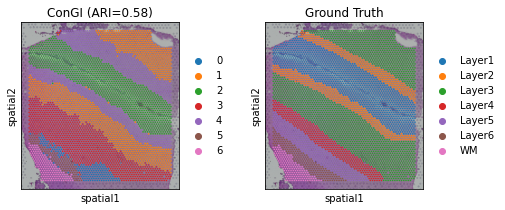

In [104]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["pred", "label"], title=[f"ConGI (ARI={adjusted_rand_score(pred, label):.2f})", "Ground Truth"])

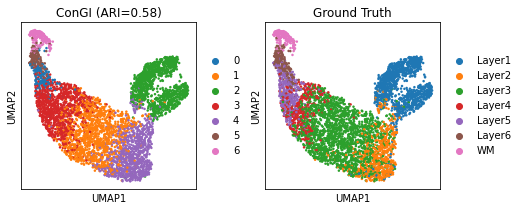

In [105]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["pred", "label"], title=[f"ConGI (ARI={adjusted_rand_score(pred, label):.2f})", "Ground Truth"])